# Homework  — Stage 10b: Time Series & Classification


In [53]:
# Imports
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
np.random.seed(7); sns.set(); plt.rcParams['figure.figsize']=(9,4)

## Synthetic Generator 

In [54]:
# Synthetic series with regimes & jumps
n=500
dates=pd.bdate_range('2021-01-01', periods=n)
mu = np.where(np.arange(n)<n//2, 0.0003, -0.0001)
sigma = np.where(np.arange(n)<n//2, 0.01, 0.015)
eps = np.random.normal(mu, sigma)
jumps = np.zeros(n); jump_days = np.random.choice(np.arange(20,n-20), size=5, replace=False)
jumps[jump_days] = np.random.normal(0,0.05,size=len(jump_days))
rets = eps + jumps
price = 100*np.exp(np.cumsum(rets))
df = pd.DataFrame({'price':price}, index=dates)
df['ret'] = df['price'].pct_change().fillna(0.0)
df['log_ret'] = np.log1p(df['ret'])
df.head(10)

,price,ret,log_ret
2021-01-01,101.735412,0.000000,0.000000
2021-01-04,101.292875,-0.004350,-0.004359
2021-01-05,101.356527,0.000628,0.000628
2021-01-06,101.800950,0.004385,0.004375
2021-01-07,101.031283,-0.007561,-0.007589
2021-01-08,101.063685,0.000321,0.000321
2021-01-11,101.093108,0.000291,0.000291
2021-01-12,99.364481,-0.017099,-0.017247
2021-01-13,100.410953,0.010532,0.010477
2021-01-14,101.046042,0.006325,0.006305


## Feature Engineering

In [55]:
df['price_lag1'] = df['price'].shift(1)
df['price_lag2'] = df['price'].shift(2)
df['price_next'] = df['price'].shift(-1)
df['price_up'] = ((df['price_next']-df['price'])>0).astype(int)
df['price_rolling_mean_5'] = df['price'].rolling(5).mean().shift(1)
df['price_rolling_mean_10'] = df['price'].rolling(10).mean().shift(1)
df_feat = df.dropna().copy()
df_feat.head()

,price,ret,log_ret,price_lag1,price_lag2,price_next,price_up,price_rolling_mean_5,price_rolling_mean_10
2021-01-15,100.446173,-0.005937,-0.005954,101.046042,100.410953,100.304093,0,100.595654,101.019532
2021-01-18,100.304093,-0.001414,-0.001415,100.446173,101.046042,100.842460,1,100.472151,100.890608
2021-01-19,100.842460,0.005367,0.005353,100.304093,100.446173,100.609424,0,100.314348,100.791729
2021-01-20,100.609424,-0.002311,-0.002314,100.842460,100.304093,100.395606,0,100.609944,100.740323
2021-01-21,100.395606,-0.002125,-0.002127,100.609424,100.842460,98.976854,0,100.649639,100.621170


## Split

In [56]:
# Time-aware split
cut=int(len(df_feat)*0.7)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]
features=['price_lag1','price_lag2','price_rolling_mean_5','price_rolling_mean_10']  # extend as you add features
X_tr, X_te = train[features], test[features]
y_tr_reg, y_te_reg = train['price_next'], test['price_next']
y_tr_clf, y_te_clf = train['price_up'], test['price_up']

## Pipeline + Model (Choose one track below)

In [58]:
# Track 1: Forecasting returns
reg = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())])
reg.fit(X_tr, y_tr_reg)
pred = reg.predict(X_te)

y_pred = reg.predict(X_te)
r2 = r2_score(y_te_reg, y_pred)

mse = mean_squared_error(y_te_reg, pred)
rmse = np.sqrt(mse)
print('R2', r2)
print('MSE:', mse)
print('RMSE:', rmse)

R2 0.9251372035275303
MSE: 1.9230588750585054
RMSE: 1.3867439832422224


### Interpretation for regression
- R_sqaure with 0.93 and low RMSE of 1.39 shows that lagged prices and short term rolling averages captures large part in predicting future price. Plot below show the actual and predicted price.
- Although it is capturing the price movement but it struggles in case of sudden jump this is expected since Linear regresion assumes stable linear relationship and can;t adapt to non linear shift or volatility breaks

Risk / Assumptions:
 - Since the model uses synthetic data generalization wouldn't ne much effective ,also since prices are predicted based on past price and moving averages but in real world there are scenerios of unpredictable shocks, liquidity changes or policy events.

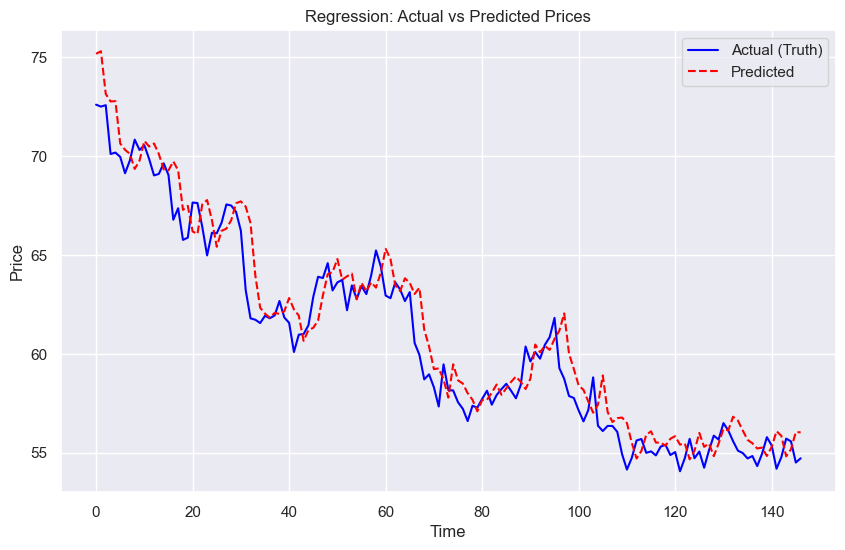

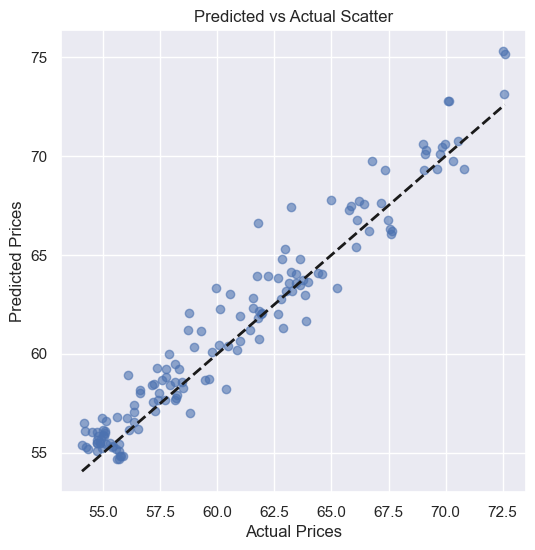

In [60]:
# Plot: Predicted vs Actual (Truth) Prices
plt.figure(figsize=(10,6))
plt.plot(y_te_reg.values, label="Actual (Truth)", color="blue")
plt.plot(y_pred, label="Predicted", color="red", linestyle="--")
plt.title("Regression: Actual vs Predicted Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

# Optional: Scatter plot for predicted vs actual
plt.figure(figsize=(6,6))
plt.scatter(y_te_reg, y_pred, alpha=0.6)
plt.plot([y_te_reg.min(), y_te_reg.max()],
         [y_te_reg.min(), y_te_reg.max()],
         'k--', lw=2)  # 45-degree line
plt.title("Predicted vs Actual Scatter")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.show()


              precision    recall  f1-score   support

           0       0.55      0.80      0.65        81
           1       0.43      0.18      0.26        66

    accuracy                           0.52       147
   macro avg       0.49      0.49      0.45       147
weighted avg       0.49      0.52      0.47       147



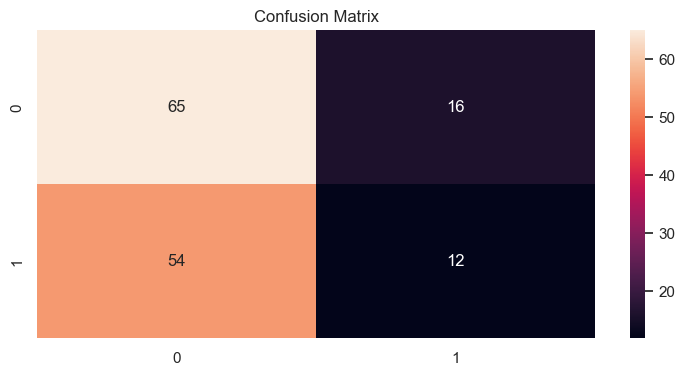

In [59]:
# Track 2: Classification (up/down)
clf = Pipeline([('scaler', StandardScaler()), ('logit', LogisticRegression(max_iter=1000))])
clf.fit(X_tr, y_tr_clf)
predc = clf.predict(X_te)
print(classification_report(y_te_clf, predc))
cm = confusion_matrix(y_te_clf, predc)
sns.heatmap(cm, annot=True, fmt='d'); plt.title('Confusion Matrix'); plt.show()

## Interpretation
Model :
 - The model have accurancy of 52% which is equivalent to random guessing. 
 - It performs better for downward price movement with recall of 0.8 but it struggle for upward movement

What failed : The imbalance in the confusion matrix indicates that the choosen feature are not that effective even though they helped in regression with some limitations.

Risk/ Assumptions : 
Predicting binary direction in financial time series is notoriously difficult due to low signal-to-noise ratio. Here, lagged and rolling averages may be insufficient to separate up vs. down days. The assumption that linear boundaries can separate classes is weak for this task, so the risk of overfitting noise or underfitting real structure is high.